In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Relevant tables

In [2]:
path = '210929_tess_5min_24h/'
df_markets = pd.read_csv(path + 'markets.csv') # PV bids
df_bids = pd.read_csv(path + 'meter_intervals.csv') # PV bids
df_hce_bids = pd.read_csv(path + 'hce_bids.csv') # HCE bids
df_bids.tail()

,meter_interval_id,meter_id,rate_id,start_time,end_time,e,qmtp,p_bid,q_bid,is_bid,mode_dispatch,mode_market
1721,1722,2,1,2021-09-23 00:00:00,2021-09-23 00:05:00,0.0,0.0,0,0.0,1,1,1
1722,1723,3,1,2021-09-23 00:00:00,2021-09-23 00:05:00,0.0,0.0,0,0.0,1,1,1
1723,1724,4,1,2021-09-23 00:00:00,2021-09-23 00:05:00,0.0,0.0,0,0.0,1,1,1
1724,1725,5,1,2021-09-23 00:00:00,2021-09-23 00:05:00,0.0,0.0,0,0.0,1,1,1
1725,1726,6,1,2021-09-23 00:00:00,2021-09-23 00:05:00,0.0,0.0,0,0.0,1,1,1


### Parameters of visualization

In [3]:
dt_sim_time = '2021-09-22 12:00:00' # or latest: df_bids['start_time'].iloc[-1]

### Compile all bids into one table (HCE + customers)

In [4]:
# HCE bids
df_auction_market = df_hce_bids.loc[df_hce_bids['start_time'] == dt_sim_time][['p_bid','q_bid','is_supply','comment']]
df_auction_market.rename(columns={'comment':'type'},inplace=True)
df_auction_market

,p_bid,q_bid,is_supply,type
432,0.529365,489.93000,0,export
433,0.539365,979.85900,1,import
434,100.000000,9.64519,0,unresp_load


In [5]:
# PV bids
df_bids = df_bids.loc[df_bids['start_time'] == dt_sim_time][['p_bid','q_bid']]
df_bids['is_supply'] = 1 # because it's PV
df_bids['type'] = 'PV'
df_bids

,p_bid,q_bid,is_supply,type
864,0,0.408345,1,PV
865,0,0.523077,1,PV
866,0,0.510540,1,PV
867,0,0.479368,1,PV
868,0,0.572327,1,PV
869,0,0.536243,1,PV


In [6]:
# Merge
df_auction_market = df_auction_market.append(df_bids)
df_auction_market

,p_bid,q_bid,is_supply,type
432,0.529365,489.930000,0,export
433,0.539365,979.859000,1,import
434,100.000000,9.645190,0,unresp_load
864,0.000000,0.408345,1,PV
865,0.000000,0.523077,1,PV
866,0.000000,0.510540,1,PV
867,0.000000,0.479368,1,PV
868,0.000000,0.572327,1,PV
869,0.000000,0.536243,1,PV


### Assemble demand curve

In [7]:
colors = {'import':'g','unresp_load':'b','PV':'y','export':'r'}

In [8]:
# Filter
df_auction_market_demand = df_auction_market.loc[df_auction_market['is_supply'] == 0]
demand_curve = df_auction_market_demand.groupby(['type','p_bid']).sum()['q_bid']
data = np.vstack((demand_curve.index.get_level_values(0),demand_curve.index.get_level_values(1)))
data = np.vstack((data,demand_curve.values))
data = data.transpose()
df_demand_curve = pd.DataFrame(columns=['type','p_bid','q_bid'],data=data)
df_demand_curve.sort_values(by='p_bid',ascending=False,inplace=True)
# Calculate positions of bars
df_demand_curve['x'] = 0.0
df_demand_curve['x_end'] = 0.0
df_demand_curve['color'] = ''
if len(df_demand_curve) > 0:
    df_demand_curve['x'].iloc[0] = df_demand_curve['q_bid'].iloc[0]/2.
    df_demand_curve['x_end'].iloc[0] = df_demand_curve['q_bid'].iloc[0]
    df_demand_curve['color'].iloc[0] = colors[df_demand_curve['type'].iloc[0]]
    for i in range(1,len(df_demand_curve)):
        df_demand_curve['x_end'].iloc[i] = df_demand_curve['x_end'].iloc[i-1] + df_demand_curve['q_bid'].iloc[i]
        df_demand_curve['x'].iloc[i] = df_demand_curve['x_end'].iloc[i-1] + df_demand_curve['q_bid'].iloc[i]/2
        df_demand_curve['color'].iloc[i] = colors[df_demand_curve['type'].iloc[i]]
#
df_demand_curve

/Users/derins/opt/anaconda3/envs/venv_tess/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,type,p_bid,q_bid,x,x_end,color
1,unresp_load,100.0,9.64519,4.822595,9.64519,b
0,export,0.529365,489.93,254.610190,499.57519,r


### Assemble supply curve

In [9]:
# Filter
df_auction_market_supply = df_auction_market.loc[df_auction_market['is_supply'] == 1]
supply_curve = df_auction_market_supply.groupby(['type','p_bid']).sum()['q_bid']
data = np.vstack((supply_curve.index.get_level_values(0),supply_curve.index.get_level_values(1)))
data = np.vstack((data,supply_curve.values))
data = data.transpose()
df_supply_curve = pd.DataFrame(columns=['type','p_bid','q_bid'],data=data)
df_supply_curve.sort_values(by='p_bid',ascending=True,inplace=True)
# Calculate positions of bars
df_supply_curve['x'] = 0.0
df_supply_curve['x_end'] = 0.0
df_supply_curve['color'] = ''
if len(df_supply_curve) > 0:
    df_supply_curve['x'].iloc[0] = df_supply_curve['q_bid'].iloc[0]/2.
    df_supply_curve['x_end'].iloc[0] = df_supply_curve['q_bid'].iloc[0]
    df_supply_curve['color'].iloc[0] = colors[df_supply_curve['type'].iloc[0]]
    for i in range(1,len(df_supply_curve)):
        df_supply_curve['x'].iloc[i] = df_supply_curve['x_end'].iloc[i-1] + df_supply_curve['q_bid'].iloc[i]/2.
        df_supply_curve['x_end'].iloc[i] = df_supply_curve['x_end'].iloc[i-1] + df_supply_curve['q_bid'].iloc[i]
        df_supply_curve['color'].iloc[i] = colors[df_supply_curve['type'].iloc[i]]
#
df_supply_curve

/Users/derins/opt/anaconda3/envs/venv_tess/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,type,p_bid,q_bid,x,x_end,color
0,PV,0.0,3.0299,1.51495,3.0299,y
1,import,0.539365,979.859,492.95940,982.8889,g


### Plot

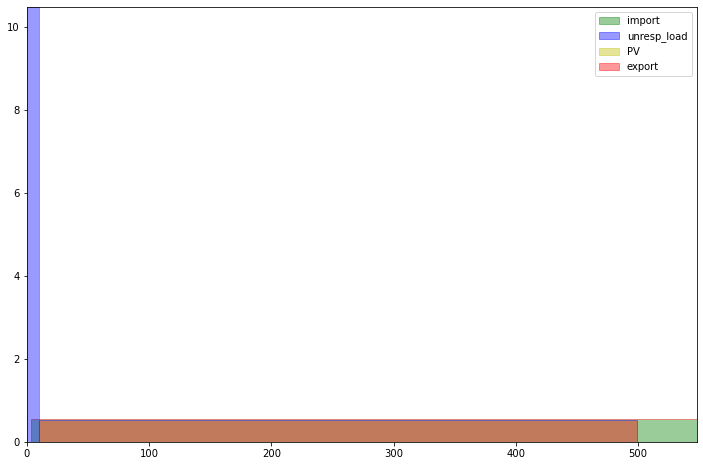

In [10]:
plt.figure(figsize=(12,8))
# Supply
plt.bar(df_supply_curve['x'],df_supply_curve['p_bid'],width=df_supply_curve['q_bid'],edgecolor=['y','r'],color=df_supply_curve['color'],alpha=0.4)
# Demand
plt.bar(df_demand_curve['x'],df_demand_curve['p_bid'],width=df_demand_curve['q_bid'],edgecolor=['g','b'],color=df_demand_curve['color'],alpha=0.4)
# Zoom in
zoom = 0.1
ending_positions = list(df_demand_curve['x_end']) + list(df_supply_curve['x_end'])
ending_positions.sort(reverse=True)
plt.xlim(0,zoom*ending_positions[0]+(1.-zoom)*ending_positions[1])
price_positions = list(df_demand_curve['p_bid']) + list(df_supply_curve['p_bid'])
price_positions.sort(reverse=True)
plt.ylim(0,zoom*price_positions[0]+(1.-zoom)*price_positions[1])
# Legend     
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, alpha=0.4, color=colors[label]) for label in labels]
plt.legend(handles, labels)